In [1]:
import h5py
import numpy as np
import skimage
import matplotlib.pyplot as plt
from astropy.io import ascii

import sys
sys.path.append('/home/z5214005/ml_icl')
from data.scripts.display_cutouts import stretch

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU') # need to trial and error to figure out which gpu I have been allocated. Not sure how else to get around this.

from supervised_model import ImageRegressor

2023-12-11 16:34:52.968019: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-11 16:34:54.565008: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/srv/scratch/z5214005/miniconda3/envs/tf2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-11 16:35:03.296675: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:18:00.0, compute capability: 7.0


In [3]:
# Open the clusters downloaded in the wide survey and look at them compared to 
# their deep counterparts
cutouts = h5py.File('/srv/scratch/mltidal/vd_cutouts.hdf')
cutouts_dud = h5py.File('/srv/scratch/z5214005/hsc_icl/cutouts.hdf')

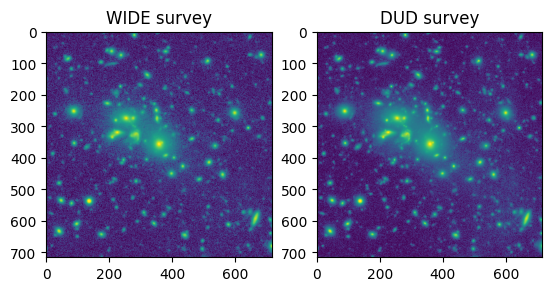

In [3]:
key = '0'

plt.subplot(121)
plt.imshow(stretch(cutouts[key]['HDU0']['DATA']))
plt.title('WIDE survey')
plt.subplot(122)
plt.title('DUD survey')
plt.imshow(stretch(cutouts_dud[key]['HDU0']['DATA']))
plt.show()

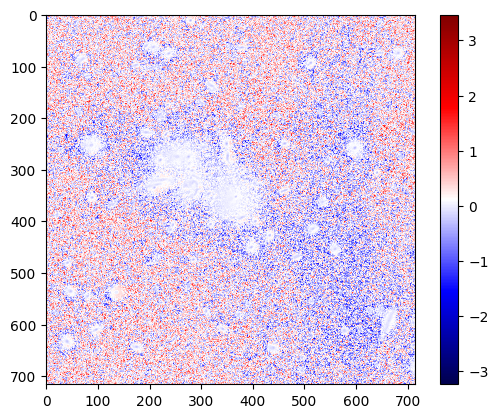

In [4]:
# What is the difference between the DUD and WIDE surveys?
key = '0'

residual = np.array(cutouts[key]['HDU0']['DATA']) - np.array(cutouts_dud[key]['HDU0']['DATA'])
plt.imshow(stretch(np.array(cutouts[key]['HDU0']['DATA'])) - stretch(np.array(cutouts_dud[key]['HDU0']['DATA'])), cmap='seismic')
plt.colorbar()
plt.show()

In [4]:
# What does the model predict on the wide images vs. the deep images?
model = ImageRegressor((224,224,1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=lambda y, p_y: -p_y.log_prob(y))
model.load_weights('../checkpoints/checkpoint-sup-weighted20cont-final.ckpt').expect_partial()

# Try one image
key = '0'
cutout = np.array(cutouts[key]['HDU0']['DATA'])
img = skimage.transform.resize(cutout, (224,224))
img = np.clip(img, a_min=0, a_max=10)
img = np.arcsinh(img / 0.017359)
img = np.expand_dims(img, 0)
img = np.expand_dims(img, -1)

prediction = model(img).mean().numpy().squeeze()
print(f'Wide prediction = {prediction}')

cutout = np.array(cutouts_dud[key]['HDU0']['DATA'])
img = skimage.transform.resize(cutout, (224,224))
img = np.clip(img, a_min=0, a_max=10)
img = np.arcsinh(img / 0.017359)
img = np.expand_dims(img, 0)
img = np.expand_dims(img, -1)
prediction = model(img).mean().numpy().squeeze()
print(f'Deep prediction = {prediction}')

2023-12-11 16:35:08.217644: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-12-11 16:35:08.328885: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-11 16:35:08.331975: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-11 16:35:08.332038: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Couldn't invoke ptxas --version
2023-12-11 16:35:08.334232: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-11 16:35:08.334349: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This mes

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


2023-12-11 16:35:08.736213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [4]
	 [[{{node shape}}]]
2023-12-11 16:35:08.736297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [4]
	 [[{{node shape}}]]
2023-12-11 16:35:08.743018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [4]
	 [[{{node shape}}]]
2023-12-11 16:35:08.743086: I tens

Wide prediction = 0.08574356138706207
Deep prediction = 0.27921926975250244


In [15]:
import sys
sys.path.append('/home/z5214005/ml_icl')

from measure_sb_cut.scripts import measure_icl
from data.scripts.display_cutouts import stretch

from astropy.cosmology import FlatLambdaCDM
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.io import ascii
from astropy.stats import sigma_clipped_stats
from photutils.segmentation import SourceFinder
import scipy
from skimage.morphology import binary_closing

cutouts = h5py.File('/srv/scratch/z5214005/hsc_icl/cutouts.hdf')
tbl = ascii.read('/srv/scratch/z5214005/camira_final.tbl', #'/../processed/camira_final.tbl', 
                    names=['ID', 'Name', 'RA [deg]', 'Dec [deg]', 'z', 'Richness', 'BCG z'])
zs = tbl['z']
richness = tbl['Richness']
cosmo = FlatLambdaCDM(H0=68.4, Om0=0.301)

def calc_icl_frac(key, cutout=None):
    # Get the image data
    if cutout is None:
        cutout = np.array(cutouts[str(key)]['HDU0']['DATA'])

    # Background estimate
    bkg = measure_icl.background_estimate(cutout, zs[key], cosmo)
    bkg_subtracted = cutout# - bkg

    # Segment the image
    cold_labels = measure_icl.create_cold_labels(cutout, np.zeros(cutout.shape, dtype=bool))
    if cold_labels is None:
        print(f'Cutout {key} returns None?? Continuing...')
        cold_labels = np.zeros_like(cutout)
    # deblended = deblend_sources(cutout, SegmentationImage(cold_labels), npixels=20, nlevels=64, progress_bar=False)
    # cold_labels = deblended.data

    # Create cold mask
    cold_mask = measure_icl.enlarge_mask(cold_labels, sigma=0.5)

    # Unsharp mask the image for hot mask creation
    kernel = Gaussian2DKernel(5) 
    conv_img = convolve(np.array(cutout), kernel)
    unsharp = np.array(cutout) - conv_img

    # Create hot mask
    hot_mask_bkg = measure_icl.background_estimate(unsharp, zs[key], cosmo=cosmo)
    hot_labels = measure_icl.create_hot_labels(unsharp, cold_mask, background=hot_mask_bkg)
    hot_mask = measure_icl.enlarge_mask(hot_labels, sigma=0.33)

    # Create the "member mask"
    mid = (cutout.shape[0] // 2, cutout.shape[1] // 2)
    # Remove the central blob from the cold labels
    central_blob = cold_labels[mid[0], mid[1]]
    unblobbed = ((cold_labels != 0) & (cold_labels != central_blob)) * cold_labels
    unblobbed = measure_icl.enlarge_mask(unblobbed, sigma=0.66) # Enlarge this mask
    # Calculate new, smaller masks for central galaxies
    threshold = measure_icl.sb2counts(25 + 10 * np.log10(1 + zs[key]))
    finder = SourceFinder(20, progress_bar=False)
    deblended = finder(bkg_subtracted, threshold)
    centrals_newlabels = deblended.data * (cold_labels == central_blob)
    # Renumber
    centrals_newlabels = (np.max(cold_labels) + centrals_newlabels) * centrals_newlabels.astype(bool)
    # Combine to create our new mask
    combined_labels = unblobbed + centrals_newlabels
    # Create the member mask
    bcg_label = combined_labels[mid[0], mid[1]]
    member_mask = (combined_labels == bcg_label) | (combined_labels == 0)
    non_member_mask = ~member_mask
    non_member_mask = non_member_mask + hot_mask
    member_mask = ~non_member_mask

    # Make the circular mask
    # Get the BCG's label
    mid = (cutout.shape[0] // 2, cutout.shape[1] // 2)
    bcg_label = combined_labels[mid[0], mid[1]]

    # Coordinates of points that are part of the BCG
    pts = np.array(np.argwhere(combined_labels == bcg_label))

    # Find points that are furthest apart
    candidates = pts[scipy.spatial.ConvexHull(pts).vertices]
    dist_mat = scipy.spatial.distance_matrix(candidates, candidates)
    i, j = np.unravel_index(dist_mat.argmax(), dist_mat.shape)
    pt1 = candidates[i]
    pt2 = candidates[j]

    size = np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)

    # Make sure that the radius is >=100kpc
    # radius = np.max((size, cosmo.arcsec_per_kpc_proper(zs[num]).value * 100 * 1/0.168))
    radius = size * 1.5

    # Generate the mask
    centre = (cutout.shape[1] // 2, cutout.shape[0] // 2)
    Y, X = np.ogrid[:cutout.shape[0], :cutout.shape[1]]
    dist_from_centre = np.sqrt((X-centre[0])**2 + (Y-centre[1])**2)
    circ_mask = dist_from_centre <= radius

    # Calculate surface brightness limit
    _, _, stddev = sigma_clipped_stats(bkg_subtracted)
    sb_lim = -2.5 * np.log10(3 * stddev/(0.168 * 10)) + 2.5 * np.log10(63095734448.0194)

    # Convert image from counts to surface brightness
    np.seterr(invalid='ignore', divide='ignore')
    sb_img = measure_icl.counts2sb(bkg_subtracted, 0)

    # Mask values below surface brightness limit
    sb_img[sb_img >= sb_lim] = np.nan

    # Mask above the surface brightness threshold
    threshold = 25 + 10 * np.log10(1 + zs[key])
    mask = sb_img >= threshold
    
    # Close the mask
    mask = binary_closing(mask)

    # Convert the SB image back to counts
    counts_img = measure_icl.sb2counts(sb_img) 

    # Close the nans to try and get rid of the noise that contributes to the ICL?
    nans = np.isnan(counts_img)
    nans = binary_closing(nans)
    not_nans = ~nans

    # Display the final image
    masked_img = counts_img * member_mask * circ_mask * not_nans

    icl = np.nansum(masked_img * mask)
    total = np.nansum(masked_img)
    frac = icl / total

    return icl, total, frac, masked_img * mask

In [5]:
# Look at the model's predictions compared to the expected fractions
precalc_fracs = np.load('/srv/scratch/mltidal/fracs_resized.npy')[2]
not_nans = np.where(~np.isnan(precalc_fracs))[0]

# Create an array of images that we have fractions for
dataset = []
expected = []
valid_ids = []
for idx in not_nans:
    if str(idx) not in cutouts_dud:
        continue
    cutout = np.array(cutouts_dud[str(idx)]['HDU0']['DATA'])
    img = skimage.transform.resize(cutout, (224,224))

    # expected.append(calc_icl_frac(idx, img)[2])

    img = np.clip(img, a_min=0, a_max=10)
    img = np.arcsinh(img / 0.017359)
    img = np.expand_dims(img, -1)
    dataset.append(img)
    expected.append(precalc_fracs[idx])
    valid_ids.append(idx)

dataset = np.array(dataset)

In [6]:
# Get predictions for all of these fractions
mean_predictions = model(dataset).mean().numpy().squeeze()

x = np.arange(0, 0.6, 0.0005)
outputs = model(dataset)
logps = []
logcs = []
for i in x:
    logps.append(outputs.log_prob(i).numpy())
    logcs.append(outputs.log_cdf(i).numpy())
logps = np.stack(logps)
logcs = np.stack(logcs)
mode_predictions = x[np.exp(logps).argmax(axis=0)]

2023-12-11 16:35:15.810907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [4]
	 [[{{node shape}}]]
2023-12-11 16:35:15.811002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [4]
	 [[{{node shape}}]]
2023-12-11 16:35:15.817925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [4]
	 [[{{node shape}}]]
2023-12-11 16:35:15.817994: I tens

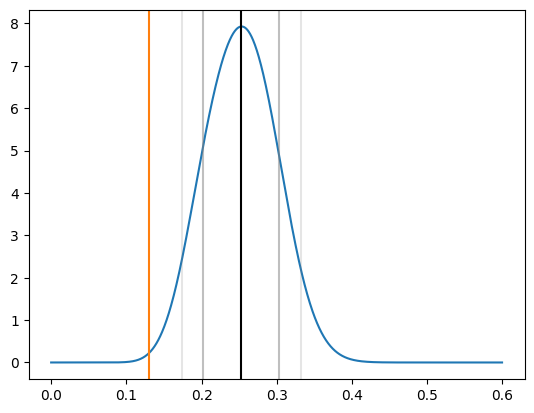

In [7]:
idx = 0
plt.plot(x, np.exp(logps[:,idx]))
plt.axvline(expected[idx], color='C1')
q15 = np.nonzero(np.exp(logcs[:,idx]) >= 0.15)[0][0]
plt.axvline(x[q15], color='gray', alpha=0.5)
q85 = np.nonzero(np.exp(logcs[:,idx]) >= 0.85)[0][0]
plt.axvline(x[q85], color='gray', alpha=0.5)
q05 = np.nonzero(np.exp(logcs[:,idx]) >= 0.05)[0][0]
plt.axvline(x[q05], color='gray', alpha=0.2)
q95 = np.nonzero(np.exp(logcs[:,idx]) >= 0.95)[0][0]
plt.axvline(x[q95], color='gray', alpha=0.2)
plt.axvline(mode_predictions[idx], color='k')
plt.show()

In [8]:
q15s = np.argmax(np.exp(logcs) >= 0.15, axis=0)
q85s = np.argmax(np.exp(logcs) >= 0.85, axis=0)

In [9]:
lower_errors = np.abs(mode_predictions - x[q15s])
upper_errors = np.abs(x[q85s] - mode_predictions)

PearsonRResult(statistic=0.4352197600664217, pvalue=3.9326082428305675e-07)
0.05170181727480888


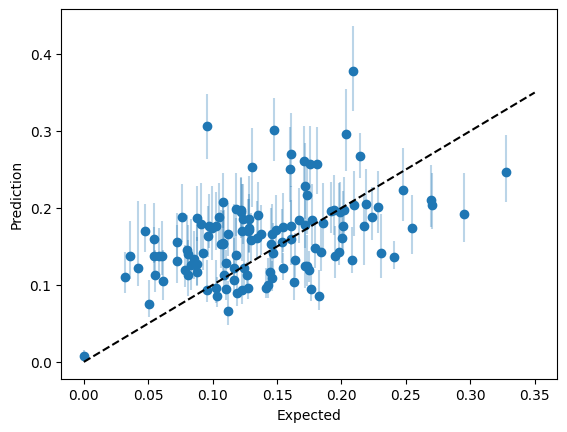

In [10]:
from scipy.stats import pearsonr

print(pearsonr(expected, mode_predictions))

plt.errorbar(expected, mode_predictions, fmt='none', yerr=(lower_errors, upper_errors), alpha=0.3)
plt.scatter(expected, mode_predictions)
print(np.mean(np.abs(expected - mode_predictions)))
plt.plot([0, 0.35], [0,0.35], 'k--')
# plt.ylim(0, 0.35)
# plt.xlim(0, 0.35)
plt.xlabel('Expected')
plt.ylabel('Prediction')
plt.show()

In [11]:
print(np.where(mode_predictions > 0.25)[0])

[  0   4  10  30  42  43  57  63  64  86 112]


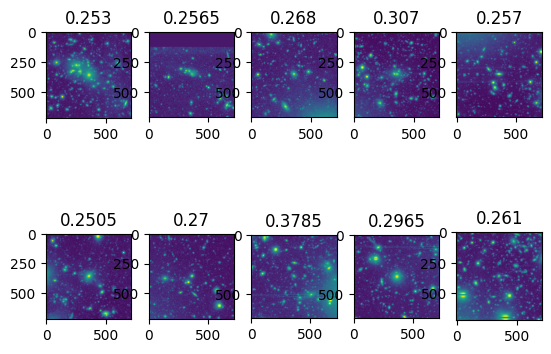

In [13]:
for i, idx in enumerate(np.where(mode_predictions > 0.25)[0][:10]):
    plt.subplot(2, 5, i+1)
    plt.imshow(stretch(cutouts_dud[str(idx)]['HDU0']['DATA']))
    plt.title(mode_predictions[idx])
plt.show()

In [39]:
# Create an array of images that we have fractions for
dataset = []
for idx in range(125):
    cutout = np.array(cutouts_dud[str(idx)]['HDU0']['DATA'])
    img = skimage.transform.resize(cutout, (224,224))

    img = np.clip(img, a_min=0, a_max=10)
    img = np.arcsinh(img / 0.017359)
    img = np.expand_dims(img, -1)
    dataset.append(img)

dataset = np.array(dataset)

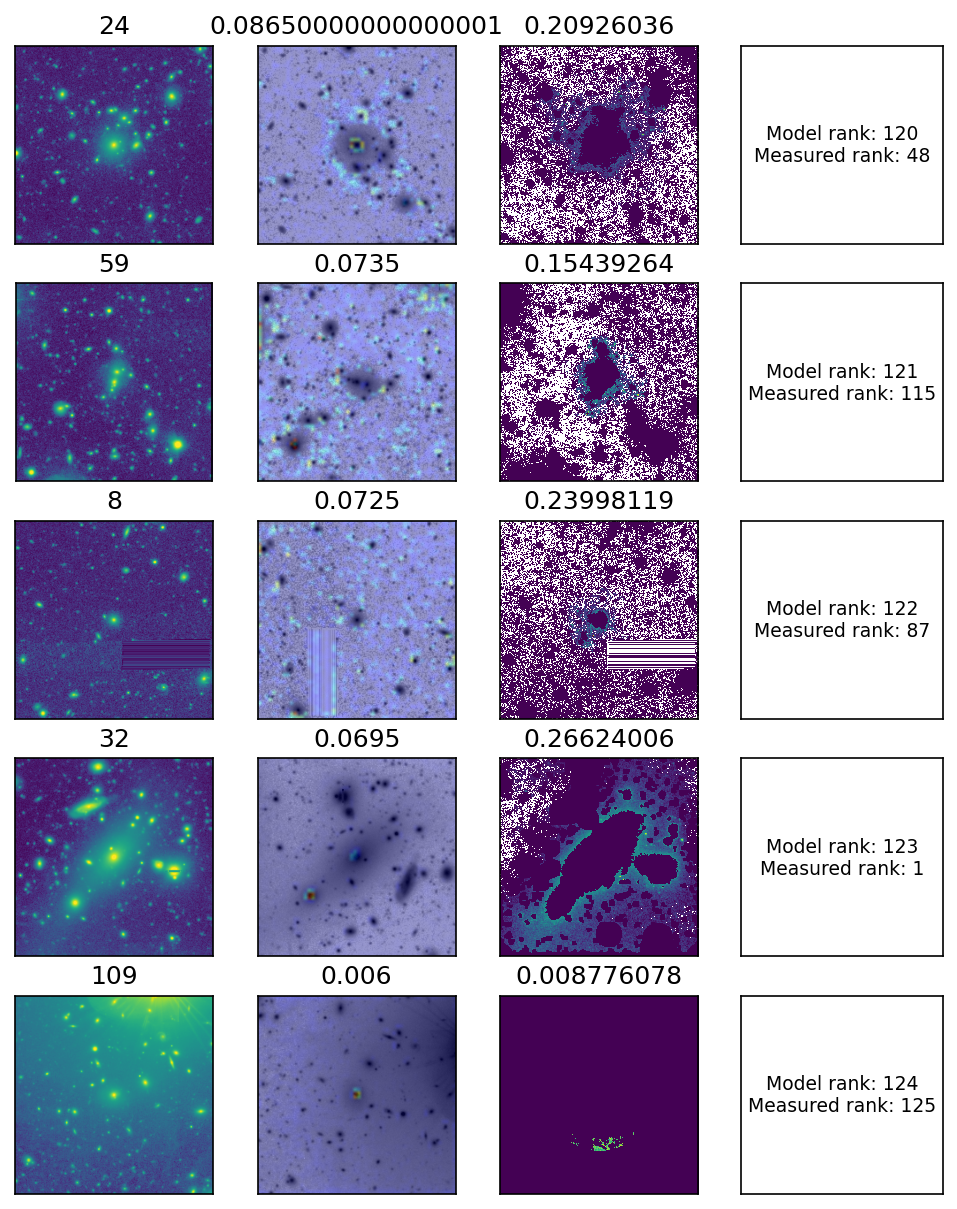

In [17]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib
from gradcam import make_grad_model, make_gradcam_heatmap

# Get the order
x = np.arange(0, 0.6, 0.0005)
outputs = model(dataset)
logps = []
logcs = []
for i in x:
    logps.append(outputs.log_prob(i).numpy())
    logcs.append(outputs.log_cdf(i).numpy())
logps = np.stack(logps)
logcs = np.stack(logcs)
mode_predictions = x[np.exp(logps).argmax(axis=0)]

order = np.argsort(mode_predictions)[::-1]

last_conv_layer_model, grad_model = make_grad_model(model)

fracs = np.load('/srv/scratch/mltidal/fracs_resized.npy')[0]

frac_ranks = 125 - np.argsort(np.argsort(fracs))

plt.close()
with PdfPages("outputs.pdf") as pdf:
    plt.figure(figsize=(8,12), dpi=150)

    for i, idx in enumerate(order):
        row = i % 6
        sp_row = row * 4
        plt.subplot(6, 4, sp_row+1)

        # Show the original image
        plt.imshow(stretch(cutouts_dud[str(idx)]['HDU0']['DATA']))
        plt.title(str(idx))
        plt.xticks([])
        plt.yticks([])

        # Show the gradcam output and model prediction
        plt.subplot(6, 4, sp_row+2)
        example = np.expand_dims(dataset[idx], 0)
        heatmap, img_array = make_gradcam_heatmap(example, model, last_conv_layer_model, grad_model)
        example = img_array
        
        # Generate a colourised version of the example image
        img = ((example - np.min(example)) / (np.max(example) - np.min(example))).squeeze()
        img = np.uint8(255*img) # rescale
        viridis = matplotlib.colormaps['gray_r']
        viridis_colours = viridis(np.arange(256))[:,:3] # get rgb values of the colourmap
        img = viridis_colours[img]

        # Generate a colourised version of the heatmap
        heatmap = np.uint8(255*heatmap)
        jet = matplotlib.colormaps.get_cmap('jet')
        jet_colours = jet(np.arange(256))[:,:3]
        jet_heatmap = jet_colours[heatmap]
        jet_heatmap = skimage.transform.resize(jet_heatmap, (img.shape[1], img.shape[0]))

        # Superimpose on the original image
        superimposed_img = jet_heatmap * 0.4 + img * 0.6
        # superimposed_img = keras.utils.array_to_img(superimposed_img)
        plt.imshow(superimposed_img)
        plt.title(mode_predictions[idx])
        plt.xticks([])
        plt.yticks([])

        # Show the calculated ICL fraction
        plt.subplot(6, 4, sp_row+3)
        cutout = np.array(cutouts_dud[str(idx)]['HDU0']['DATA'])
        img = skimage.transform.resize(cutout, (224,224))
        measurement = calc_icl_frac(idx, img)
        if measurement is None:
            plt.imshow(np.zeros_like(img))
            plt.title(np.nan)
        else:
            plt.imshow(measurement[3], interpolation='none')
            plt.title(measurement[2])
        plt.xticks([])
        plt.yticks([])

        # Show the rank comparison
        plt.subplot(6, 4, sp_row+4)
        text_kwargs = dict(ha='center', va='center', fontsize=9, color='k')
        plt.text(0.5, 0.5, f'Model rank: {i}\nMeasured rank: {frac_ranks[idx]}', **text_kwargs)
        plt.xticks([])
        plt.yticks([])

        if sp_row + 4 == 24: 
            # end of page
            pdf.savefig()
            plt.close()
            plt.figure(figsize=(8,12), dpi=150)
    pdf.savefig()
    plt.close()

PearsonRResult(statistic=0.08011547189813106, pvalue=0.37446100159952056)


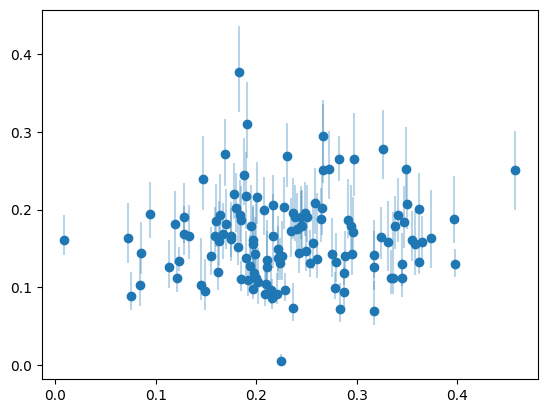

In [19]:
expected = []

for idx in order:
    cutout = np.array(cutouts_dud[str(idx)]['HDU0']['DATA'])
    img = skimage.transform.resize(cutout, (224,224))
    measurement = calc_icl_frac(idx, img)
    expected.append(measurement[2])

print(pearsonr(expected, mode_predictions))

plt.errorbar(expected, mode_predictions, fmt='none', yerr=(lower_errors, upper_errors), alpha=0.3)
plt.scatter(expected, mode_predictions)

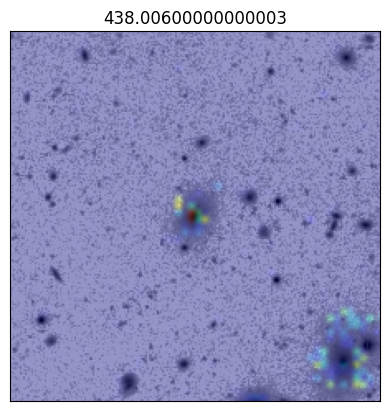

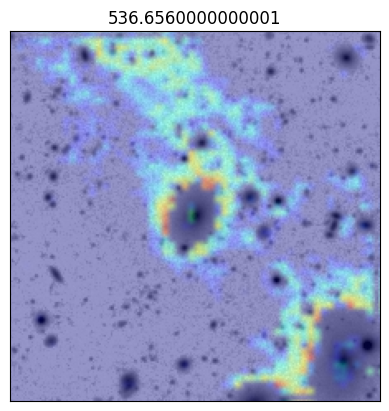

In [28]:
# Look at the outputs of the model on a wide version and deep version of the same image
cutout_num = 114

def show_gradcam(cutouts, cutout_num):
    cutout = cutouts[str(cutout_num)]['HDU0']['DATA']
    img = skimage.transform.resize(cutout, (224,224))
    img = np.clip(img, a_min=0, a_max=10)
    img = np.arcsinh(img / 0.017359)
    img = np.expand_dims(img, -1)

    # Show the gradcam output and model prediction
    example = np.expand_dims(img, 0)
    heatmap, img_array = make_gradcam_heatmap(example, model, last_conv_layer_model, grad_model)
    example = img_array

    # Generate a colourised version of the example image
    img = ((example - np.min(example)) / (np.max(example) - np.min(example))).squeeze()
    img = np.uint8(255*img) # rescale
    viridis = matplotlib.colormaps['gray_r']
    viridis_colours = viridis(np.arange(256))[:,:3] # get rgb values of the colourmap
    img = viridis_colours[img]

    # Generate a colourised version of the heatmap
    heatmap = np.uint8(255*heatmap)
    jet = matplotlib.colormaps.get_cmap('jet')
    jet_colours = jet(np.arange(256))[:,:3]
    jet_heatmap = jet_colours[heatmap]
    jet_heatmap = skimage.transform.resize(jet_heatmap, (img.shape[1], img.shape[0]))

    # Superimpose on the original image
    superimposed_img = jet_heatmap * 0.4 + img * 0.6
    # superimposed_img = keras.utils.array_to_img(superimposed_img)
    plt.imshow(superimposed_img)
    x = np.arange(0, 1.0, 0.0005)
    output = model(example)
    logps = []
    logcs = []
    for i in x:
        logps.append(output.log_prob(i).numpy())
        logcs.append(output.log_cdf(i).numpy())
    logps = np.stack(logps)
    logcs = np.stack(logcs)
    prediction = x[np.exp(logps).argmax(axis=0)][0]
    plt.title(prediction * 1973)
    plt.xticks([])
    plt.yticks([])
    plt.show()

show_gradcam(cutouts, cutout_num)
show_gradcam(cutouts_dud, cutout_num)

25.083108212077782
136.137


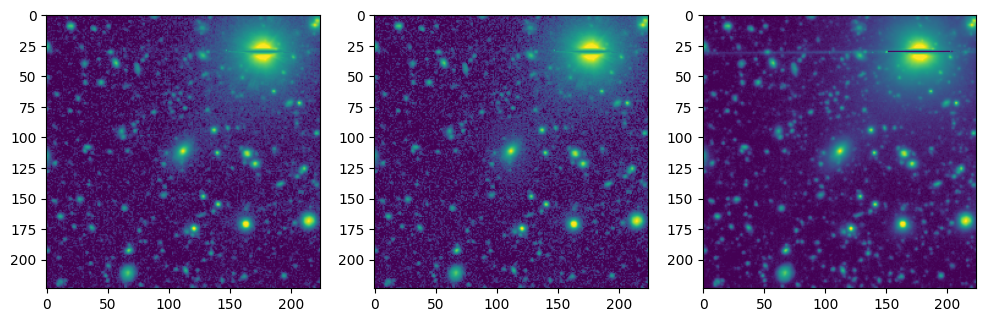

In [90]:
from generate_train_data import inject_icl
from astropy.io import ascii

cutout_num = 46

tbl = ascii.read('/srv/scratch/z5214005/camira_final.tbl')
z = tbl['z_cl'][cutout_num]
cutout = cutouts[str(cutout_num)]['HDU0']['DATA']
img = skimage.transform.resize(cutout, (224,224))
cutouts = {}
cutouts[str(cutout_num)] = {}
cutouts[str(cutout_num)]['HDU0'] = {}
cutouts[str(cutout_num)]['HDU0']['DATA'] = img
result = inject_icl(str(cutout_num), cutouts, z)
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(stretch(cutouts[str(cutout_num)]['HDU0']['DATA']))
plt.subplot(132)
plt.imshow(stretch(result['img']))
print(result['icl'])
cutout = result['img']
img = np.clip(img, a_min=0, a_max=10)
img = np.arcsinh(img / 0.017359)
img = np.expand_dims(img, -1)
example = np.expand_dims(img, 0)

x = np.arange(0, 1.0, 0.0005)
output = model(example)
logps = []
logcs = []
for i in x:
    logps.append(output.log_prob(i).numpy())
    logcs.append(output.log_cdf(i).numpy())
logps = np.stack(logps)
logcs = np.stack(logcs)
print(x[np.exp(logps).argmax(axis=0)][0] * 1973)
plt.subplot(133)
cutout = cutouts_dud[str(cutout_num)]['HDU0']['DATA']
img = skimage.transform.resize(cutout, (224,224))
plt.imshow(stretch(img))
plt.show()

In [89]:
import generate_train_data
importlib.reload(generate_train_data)
from generate_train_data import inject_icl